# A1 - Proposta de Modelo de Síntese de Dado Tabular em Saúde

#### Aluno: Tiago Amorim (100.675)

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.dates as mdates
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

In [114]:
df_agg = pd.read_csv('./data_agg.csv', parse_dates=['Date'])
# df_agg.head()

In [115]:
columns = df_agg.columns[-7:]
columns

Index(['Age', 'Sex', 'PLAQUETAS SANGUE', 'NEUTRÓFILOS ABSOLUTO',
       'LINFÓCITOS ABSOLUTO', 'NEUTRÓFILOS %', 'LINFÓCITOS %'],
      dtype='object')

# Geração de Amostras com VAE

In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

In [117]:
# Baseado em: https://hunterheidenreich.com/posts/modern-variational-autoencoder-in-pytorch/

@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.

    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.

        loss_mse (torch.Tensor): The reconstruction loss MSE component of the VAE loss.
        loss_bin (torch.Tensor): The reconstruction loss binary CE component of the VAE loss.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor

    loss: torch.Tensor

    loss_recon_mse: torch.Tensor
    loss_recon_bin: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor


In [118]:
class SigmoidFirstValue(nn.Module):
    def __init__(self):
        super(SigmoidFirstValue, self).__init__()

    def forward(self, x):
        mask = torch.concat((torch.ones_like(x[:,:1]), torch.zeros_like(x[:,1:])), dim=1)
        xs = torch.sigmoid(x) * mask
        return xs + x * (1 - mask)

In [119]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.

    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
        beta (float): Weight for the KL divergence term.
        alpha (float): Weight for the MSE loss term.
    """

    def __init__(self, input_dim, hidden_dim, latent_dim, beta=1.0, alpha=0.9, n_hidden_layers=2):
        super(VAE, self).__init__()
        assert n_hidden_layers >= 1, 'Number of hidden layers must be at least 1.'

        self.latent_dim = latent_dim
        self.beta = beta
        self.alpha = alpha

        self.encoder = nn.Sequential()
        self.encoder.add_module('input_linear',nn.Linear(input_dim, hidden_dim))
        self.encoder.add_module('input_act',nn.SiLU())
        for i in range(n_hidden_layers):
            self.encoder.add_module(f'{i+1}_linear',nn.Linear(hidden_dim, hidden_dim))
            self.encoder.add_module(f'{i+1}_act',nn.SiLU())
        self.encoder.add_module('output_linear',nn.Linear(hidden_dim, 2 * latent_dim)) # mean and variance

        self.softplus = nn.Softplus()

        self.decoder = nn.Sequential()
        self.decoder.add_module('input_linear',nn.Linear(latent_dim, hidden_dim))
        self.decoder.add_module('input_act',nn.SiLU())
        for i in range(n_hidden_layers):
            self.decoder.add_module(f'{i+1}_linear',nn.Linear(hidden_dim, hidden_dim))
            self.decoder.add_module(f'{i+1}_act',nn.SiLU())
        self.decoder.add_module('output_linear',nn.Linear(hidden_dim, input_dim))

        self.sigmoid_first_value = SigmoidFirstValue()

    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.

        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.

        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)

        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)

    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.

        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.
        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()

    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.

        Args:
            z (torch.Tensor): Data in the latent space.

        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        x_recon = self.decoder(z)
        x_recon = self.sigmoid_first_value(x_recon)
        return x_recon

    def forward(self, x, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.

        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.

        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)

        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon_mse=None,
                loss_recon_bin=None,
                loss_recon=None,
                loss_kl=None,
            )

        mask = torch.concat((torch.ones_like(x[:,:1]), torch.zeros_like(x[:,1:])), dim=1)

        loss_recon_bin = F.binary_cross_entropy(recon_x * mask, x * mask, reduction='mean')
        loss_recon_mse = F.mse_loss(recon_x * (1-mask), x * (1-mask), reduction='mean')
        loss_recon = (1 - self.alpha) * loss_recon_bin + self.alpha * loss_recon_mse

        # loss_recon = F.mse_loss(recon_x, x, reduction='mean')

        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()

        loss = loss_recon + self.beta * loss_kl

        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon_mse=None, #loss_recon_mse.detach(),
            loss_recon_bin=None, #loss_recon_bin.detach(),
            loss_recon=loss_recon.detach(),
            loss_kl=loss_kl.detach(),
        )

    def samples(self, n_samples = 1):
        """
        Gets samples from the latent space.

        Args:
            n_samples (int): Number of samples to generate.

        Returns:
            torch.Tensor: Samples from the latent space.
        """
        device = next(self.parameters()).device
        z = torch.randn(n_samples, self.latent_dim, device=device)
        return self.decode(z)


## Data Tensors

In [120]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [121]:
columns = list(columns)
columns[0], columns[1] = columns[1], columns[0]

X_values = df_agg[columns].values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_values)
X_train_scaled, X_test_scaled = train_test_split(X_scaled, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)

## Training Functions

In [122]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [123]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [124]:
def reconstruction_fig(model, data, scaler, scaled=True):
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        data = data.to(device)
        output = model(data, compute_loss=False)
        recon = output.x_recon.cpu().numpy()
        data = data.cpu().numpy()

        if not scaled:
            data = scaler.inverse_transform(data)
            recon = scaler.inverse_transform(recon)

        if len(data.shape) == 1:
            data = data.reshape(1, -1)
            recon = recon.reshape(1, -1)
        n_samples = data.shape[0]

        fig, ax = plt.subplots(n_samples, 1, figsize=(4, 2*n_samples))
        if n_samples == 1:
            ax = [ax]
        for i in range(n_samples):
            ax[i].plot(data[i], label='Original', color='blue', marker='o')
            ax[i].plot(recon[i], label='Reconstructed', color='blue', marker='o', linestyle='--')
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].set_ylim(0, 1)
        ax[0].legend()
        plt.tight_layout()
        return fig

def density_fig(model, data, scaler, scaled=True):
    model.eval()
    with torch.no_grad():
        samples = model.samples(10000).to('cpu').detach().numpy()
        data = data.cpu().numpy()

        if not scaled:
            samples = scaler.inverse_transform(samples)
            data = scaler.inverse_transform(data)

        if len(data.shape) == 1:
            data = data.reshape(1, -1)
            recon = recon.reshape(1, -1)
        n_plots = data.shape[1]

        fig, ax = plt.subplots(n_plots, 1, figsize=(4, 2*n_plots))
        if n_plots == 1:
            ax = [ax]
        for i in range(n_plots):
            sns.kdeplot(data[:,i], label='Original', ax=ax[i], bw_adjust=0.5, color='blue')
            sns.kdeplot(samples[:,i], label='Synthetic', ax=ax[i], bw_adjust=0.5, color='blue', linestyle='--')
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].set_ylabel(columns[i])
        ax[0].legend()
        plt.tight_layout()
        return fig

In [125]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.

    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode
    device = next(model.parameters()).device
    batch_size = dataloader.batch_size

    for batch_idx, data in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx

        data = data.to(device)
        optimizer.zero_grad()  # Zero the gradients
        output = model(data)  # Forward pass
        loss = output.loss
        loss.backward(retain_graph=True)

        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)

            # print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon Bin: {output.loss_recon_bin.item():.4f}, Recon MSE: {output.loss_recon_mse.item():.4f}, Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', output.loss_kl.item(), global_step)
                writer.add_scalar('Loss/Train/Recon', output.loss_recon.item(), global_step)
                # writer.add_scalar('Loss/Train/BCE', output.loss_recon_bin.item(), global_step)
                # writer.add_scalar('Loss/Train/MSE', output.loss_recon_mse.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()  # Update the model parameters

    return prev_updates + len(dataloader)

In [126]:
def test(model, dataloader, cur_step, writer=None):
    """
    Tests the model on the given data.

    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    device = next(model.parameters()).device

    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0

    with torch.no_grad():
        for data in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data

            output = model(data, compute_loss=True)  # Forward pass

            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (Recon: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')

    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/Recon', output.loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', output.loss_kl.item(), global_step=cur_step)

        inputs = next(iter(dataloader))
        writer.add_figure('Plots/Reconstruction', reconstruction_fig(model, inputs[:5], scaler, scaled=True), global_step=cur_step)
        all_samples = []
        for batch in dataloader:
            all_samples.append(batch)
        inputs = torch.cat(all_samples, dim=0)
        writer.add_figure('Plots/Density', density_fig(model, inputs, scaler, scaled=True), global_step=cur_step)

    return test_loss, test_recon_loss, test_kl_loss


In [127]:
def get_dataloaders(batch_size, X_train, X_test):
    train_loader = torch.utils.data.DataLoader(
        X_train,
        batch_size=batch_size,
        shuffle=True,
    )
    test_loader = torch.utils.data.DataLoader(
        X_test,
        batch_size=batch_size,
        shuffle=False,
    )
    return train_loader, test_loader


def build_vae(options):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = VAE(
        input_dim=7,
        hidden_dim=options['hidden_dim'],
        latent_dim=options['latent_dim'],
        beta=options['beta'],
        alpha=options['alpha'],
        n_hidden_layers=options['n_hidden_layers']
        ).to(device)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=options['learning_rate'],
        weight_decay=options['weight_decay'])
    model_name = f'{options["study_name"]}/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}'
    writer = SummaryWriter(f'runs/{model_name}')
    print(f"Model name: {model_name}")
    return model, optimizer, writer


def train_vae(options, model, optimizer, writer, train_loader, test_loader):
    prev_updates = 0
    best_loss = float('inf')
    best_losses = {}

    for epoch in range(options['num_epochs']):
        print(f'Epoch {epoch+1}/{options["num_epochs"]}')
        prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
        test_loss, test_recon_loss, test_kl_loss = test(model, test_loader, prev_updates, writer=writer)
        if test_loss < best_loss:
            best_loss = test_loss
            best_losses = {
                'hparam/test_loss': test_loss,
                'hparam/recon_loss': test_recon_loss,
                'hparam/kl_loss': test_kl_loss,
            }
    writer.add_hparams(options, best_losses)
    writer.flush()
    writer.close()


def run_vae(options, X_train, X_test):
    model, optimizer, writer = build_vae(options)
    print(f"Number of parameters in the model: {count_parameters(model)}")

    train_loader, test_loader = get_dataloaders(options['batch_size'], X_train, X_test)
    train_vae(options, model, optimizer, writer, train_loader, test_loader)
    return model

## Model Training

In [132]:
options = {
    'batch_size': 128,
    'learning_rate': 1e-3,
    'weight_decay': 1e-2,
    'num_epochs': 30,
    'latent_dim': 5,
    'hidden_dim': 12,
    'n_hidden_layers': 4,
    'beta': 0.006,
    'alpha': 0.90,
    'study_name': 'vae05',
    }

model = run_vae(options, X_train, X_test)

Model name: vae05/vae_20240903-091208
Number of parameters in the model: 1637
Epoch 1/30


  0%|          | 0/365 [00:00<?, ?it/s]

  1%|          | 3/365 [00:00<00:13, 26.46it/s]

Step 0 (N samples: 0), Loss: 0.1950 (Recon: 0.1922, KL: 0.4736) Grad: 0.3285


 33%|███▎      | 122/365 [00:01<00:01, 130.43it/s]

Step 100 (N samples: 12,800), Loss: 0.0259 (Recon: 0.0243, KL: 0.2568) Grad: 0.0423


 62%|██████▏   | 228/365 [00:01<00:00, 149.01it/s]

Step 200 (N samples: 25,600), Loss: 0.0185 (Recon: 0.0183, KL: 0.0303) Grad: 0.0135


 87%|████████▋ | 319/365 [00:02<00:00, 142.25it/s]

Step 300 (N samples: 38,400), Loss: 0.0197 (Recon: 0.0197, KL: 0.0007) Grad: 0.0105


Testing: 100%|██████████| 92/92 [00:00<00:00, 321.10it/s]


====> Test set loss: 0.0200 (Recon: 0.0200, KLD: 0.0003)
Epoch 2/30


 16%|█▌        | 59/365 [00:00<00:02, 117.84it/s]

Step 400 (N samples: 51,200), Loss: 0.0189 (Recon: 0.0189, KL: 0.0003) Grad: 0.0062


 42%|████▏     | 153/365 [00:01<00:01, 146.72it/s]

Step 500 (N samples: 64,000), Loss: 0.0204 (Recon: 0.0204, KL: 0.0003) Grad: 0.0086


 71%|███████   | 258/365 [00:01<00:00, 146.24it/s]

Step 600 (N samples: 76,800), Loss: 0.0203 (Recon: 0.0203, KL: 0.0004) Grad: 0.0105


100%|██████████| 365/365 [00:02<00:00, 136.53it/s]


Step 700 (N samples: 89,600), Loss: 0.0203 (Recon: 0.0203, KL: 0.0004) Grad: 0.0173


Testing: 100%|██████████| 92/92 [00:00<00:00, 336.13it/s]


====> Test set loss: 0.0200 (Recon: 0.0200, KLD: 0.0004)
Epoch 3/30


 27%|██▋       | 99/365 [00:00<00:01, 140.66it/s]

Step 800 (N samples: 102,400), Loss: 0.0207 (Recon: 0.0207, KL: 0.0004) Grad: 0.0092


 54%|█████▎    | 196/365 [00:01<00:01, 157.08it/s]

Step 900 (N samples: 115,200), Loss: 0.0212 (Recon: 0.0212, KL: 0.0005) Grad: 0.0042


 81%|████████  | 295/365 [00:02<00:00, 160.93it/s]

Step 1,000 (N samples: 128,000), Loss: 0.0192 (Recon: 0.0192, KL: 0.0003) Grad: 0.0051


Testing: 100%|██████████| 92/92 [00:00<00:00, 338.89it/s]


====> Test set loss: 0.0200 (Recon: 0.0200, KLD: 0.0003)
Epoch 4/30


  1%|▏         | 5/365 [00:00<00:08, 43.36it/s]

Step 1,100 (N samples: 140,800), Loss: 0.0211 (Recon: 0.0210, KL: 0.0004) Grad: 0.0180


 37%|███▋      | 136/365 [00:01<00:01, 152.20it/s]

Step 1,200 (N samples: 153,600), Loss: 0.0210 (Recon: 0.0210, KL: 0.0004) Grad: 0.0110


 65%|██████▍   | 237/365 [00:01<00:00, 158.67it/s]

Step 1,300 (N samples: 166,400), Loss: 0.0205 (Recon: 0.0205, KL: 0.0003) Grad: 0.0101


 92%|█████████▏| 334/365 [00:02<00:00, 155.58it/s]

Step 1,400 (N samples: 179,200), Loss: 0.0205 (Recon: 0.0205, KL: 0.0003) Grad: 0.0077


Testing: 100%|██████████| 92/92 [00:00<00:00, 309.33it/s]


====> Test set loss: 0.0200 (Recon: 0.0200, KLD: 0.0003)
Epoch 5/30


 19%|█▊        | 68/365 [00:00<00:02, 119.34it/s]

Step 1,500 (N samples: 192,000), Loss: 0.0206 (Recon: 0.0206, KL: 0.0004) Grad: 0.0091


 44%|████▍     | 162/365 [00:01<00:01, 145.01it/s]

Step 1,600 (N samples: 204,800), Loss: 0.0187 (Recon: 0.0187, KL: 0.0004) Grad: 0.0154


 71%|███████   | 259/365 [00:02<00:00, 152.69it/s]

Step 1,700 (N samples: 217,600), Loss: 0.0194 (Recon: 0.0194, KL: 0.0004) Grad: 0.0081


100%|██████████| 365/365 [00:02<00:00, 135.94it/s]


Step 1,800 (N samples: 230,400), Loss: 0.0191 (Recon: 0.0191, KL: 0.0004) Grad: 0.0151


Testing: 100%|██████████| 92/92 [00:00<00:00, 329.89it/s]


====> Test set loss: 0.0200 (Recon: 0.0200, KLD: 0.0004)
Epoch 6/30


 26%|██▋       | 96/365 [00:00<00:01, 145.55it/s]

Step 1,900 (N samples: 243,200), Loss: 0.0197 (Recon: 0.0197, KL: 0.0004) Grad: 0.0120


 52%|█████▏    | 190/365 [00:01<00:01, 150.14it/s]

Step 2,000 (N samples: 256,000), Loss: 0.0222 (Recon: 0.0222, KL: 0.0006) Grad: 0.0145


 83%|████████▎ | 302/365 [00:02<00:00, 150.36it/s]

Step 2,100 (N samples: 268,800), Loss: 0.0209 (Recon: 0.0209, KL: 0.0005) Grad: 0.0205


Testing: 100%|██████████| 92/92 [00:00<00:00, 344.43it/s]


====> Test set loss: 0.0200 (Recon: 0.0200, KLD: 0.0005)
Epoch 7/30


  6%|▋         | 23/365 [00:00<00:06, 54.53it/s]

Step 2,200 (N samples: 281,600), Loss: 0.0198 (Recon: 0.0198, KL: 0.0005) Grad: 0.0167


 36%|███▌      | 131/365 [00:01<00:01, 144.00it/s]

Step 2,300 (N samples: 294,400), Loss: 0.0211 (Recon: 0.0211, KL: 0.0006) Grad: 0.0189


 62%|██████▏   | 228/365 [00:01<00:00, 154.50it/s]

Step 2,400 (N samples: 307,200), Loss: 0.0222 (Recon: 0.0222, KL: 0.0007) Grad: 0.0098


 90%|████████▉ | 327/365 [00:02<00:00, 151.77it/s]

Step 2,500 (N samples: 320,000), Loss: 0.0202 (Recon: 0.0202, KL: 0.0005) Grad: 0.0154


Testing: 100%|██████████| 92/92 [00:00<00:00, 326.65it/s]


====> Test set loss: 0.0200 (Recon: 0.0200, KLD: 0.0005)
Epoch 8/30


 18%|█▊        | 67/365 [00:00<00:02, 121.59it/s]

Step 2,600 (N samples: 332,800), Loss: 0.0201 (Recon: 0.0201, KL: 0.0005) Grad: 0.0191


 46%|████▌     | 168/365 [00:01<00:01, 154.95it/s]

Step 2,700 (N samples: 345,600), Loss: 0.0190 (Recon: 0.0190, KL: 0.0005) Grad: 0.0237


 73%|███████▎  | 267/365 [00:02<00:00, 156.41it/s]

Step 2,800 (N samples: 358,400), Loss: 0.0187 (Recon: 0.0187, KL: 0.0005) Grad: 0.0109


100%|██████████| 365/365 [00:02<00:00, 136.86it/s]


Step 2,900 (N samples: 371,200), Loss: 0.0253 (Recon: 0.0253, KL: 0.0009) Grad: 0.0211


Testing: 100%|██████████| 92/92 [00:00<00:00, 343.06it/s]


====> Test set loss: 0.0200 (Recon: 0.0200, KLD: 0.0006)
Epoch 9/30


 29%|██▉       | 107/365 [00:00<00:01, 142.05it/s]

Step 3,000 (N samples: 384,000), Loss: 0.0209 (Recon: 0.0209, KL: 0.0006) Grad: 0.0090


 58%|█████▊    | 210/365 [00:01<00:00, 158.35it/s]

Step 3,100 (N samples: 396,800), Loss: 0.0204 (Recon: 0.0204, KL: 0.0008) Grad: 0.0073


 85%|████████▌ | 312/365 [00:02<00:00, 159.34it/s]

Step 3,200 (N samples: 409,600), Loss: 0.0207 (Recon: 0.0207, KL: 0.0009) Grad: 0.0179


Testing: 100%|██████████| 92/92 [00:00<00:00, 327.45it/s]


====> Test set loss: 0.0200 (Recon: 0.0200, KLD: 0.0007)
Epoch 10/30


  7%|▋         | 26/365 [00:00<00:05, 62.94it/s]

Step 3,300 (N samples: 422,400), Loss: 0.0188 (Recon: 0.0188, KL: 0.0006) Grad: 0.0141


 36%|███▋      | 133/365 [00:01<00:01, 143.31it/s]

Step 3,400 (N samples: 435,200), Loss: 0.0209 (Recon: 0.0209, KL: 0.0007) Grad: 0.0066


 67%|██████▋   | 246/365 [00:01<00:00, 152.12it/s]

Step 3,500 (N samples: 448,000), Loss: 0.0213 (Recon: 0.0213, KL: 0.0007) Grad: 0.0052


 95%|█████████▍| 345/365 [00:02<00:00, 160.45it/s]

Step 3,600 (N samples: 460,800), Loss: 0.0197 (Recon: 0.0197, KL: 0.0007) Grad: 0.0091


Testing: 100%|██████████| 92/92 [00:00<00:00, 336.73it/s]


====> Test set loss: 0.0200 (Recon: 0.0200, KLD: 0.0008)
Epoch 11/30


 22%|██▏       | 81/365 [00:00<00:02, 137.13it/s]

Step 3,700 (N samples: 473,600), Loss: 0.0208 (Recon: 0.0208, KL: 0.0012) Grad: 0.0094


 46%|████▌     | 167/365 [00:01<00:01, 160.65it/s]

Step 3,800 (N samples: 486,400), Loss: 0.0197 (Recon: 0.0197, KL: 0.0011) Grad: 0.0110


 74%|███████▍  | 270/365 [00:01<00:00, 161.41it/s]

Step 3,900 (N samples: 499,200), Loss: 0.0186 (Recon: 0.0186, KL: 0.0011) Grad: 0.0087


100%|██████████| 365/365 [00:02<00:00, 146.04it/s]


Step 4,000 (N samples: 512,000), Loss: 0.0195 (Recon: 0.0195, KL: 0.0023) Grad: 0.0157


Testing: 100%|██████████| 92/92 [00:00<00:00, 332.47it/s]


====> Test set loss: 0.0200 (Recon: 0.0200, KLD: 0.0024)
Epoch 12/30


 32%|███▏      | 115/365 [00:00<00:01, 161.55it/s]

Step 4,100 (N samples: 524,800), Loss: 0.0183 (Recon: 0.0183, KL: 0.0042) Grad: 0.0072


 60%|█████▉    | 218/365 [00:01<00:00, 165.58it/s]

Step 4,200 (N samples: 537,600), Loss: 0.0209 (Recon: 0.0208, KL: 0.0223) Grad: 0.0103


 84%|████████▎ | 305/365 [00:01<00:00, 166.50it/s]

Step 4,300 (N samples: 550,400), Loss: 0.0198 (Recon: 0.0192, KL: 0.1022) Grad: 0.0115


Testing: 100%|██████████| 92/92 [00:00<00:00, 333.85it/s]


====> Test set loss: 0.0196 (Recon: 0.0186, KLD: 0.1692)
Epoch 13/30


  9%|▉         | 32/365 [00:00<00:04, 69.49it/s]

Step 4,400 (N samples: 563,200), Loss: 0.0209 (Recon: 0.0198, KL: 0.1866) Grad: 0.0061


 40%|████      | 146/365 [00:01<00:01, 151.41it/s]

Step 4,500 (N samples: 576,000), Loss: 0.0202 (Recon: 0.0188, KL: 0.2272) Grad: 0.0100


 67%|██████▋   | 243/365 [00:01<00:00, 158.91it/s]

Step 4,600 (N samples: 588,800), Loss: 0.0194 (Recon: 0.0176, KL: 0.2922) Grad: 0.0126


 95%|█████████▍| 345/365 [00:02<00:00, 161.16it/s]

Step 4,700 (N samples: 601,600), Loss: 0.0185 (Recon: 0.0167, KL: 0.2996) Grad: 0.0170


Testing: 100%|██████████| 92/92 [00:00<00:00, 344.27it/s]


====> Test set loss: 0.0192 (Recon: 0.0171, KLD: 0.3526)
Epoch 14/30


 24%|██▍       | 89/365 [00:00<00:01, 139.99it/s]

Step 4,800 (N samples: 614,400), Loss: 0.0194 (Recon: 0.0174, KL: 0.3269) Grad: 0.0101


 52%|█████▏    | 188/365 [00:01<00:01, 158.68it/s]

Step 4,900 (N samples: 627,200), Loss: 0.0186 (Recon: 0.0168, KL: 0.3085) Grad: 0.0084


 78%|███████▊  | 286/365 [00:02<00:00, 158.72it/s]

Step 5,000 (N samples: 640,000), Loss: 0.0207 (Recon: 0.0182, KL: 0.4136) Grad: 0.0244


100%|██████████| 365/365 [00:02<00:00, 140.83it/s]


Step 5,100 (N samples: 652,800), Loss: 0.0188 (Recon: 0.0166, KL: 0.3619) Grad: 0.0069


Testing: 100%|██████████| 92/92 [00:00<00:00, 324.78it/s]


====> Test set loss: 0.0188 (Recon: 0.0167, KLD: 0.3551)
Epoch 15/30


 32%|███▏      | 118/365 [00:01<00:01, 152.47it/s]

Step 5,200 (N samples: 665,600), Loss: 0.0191 (Recon: 0.0166, KL: 0.4116) Grad: 0.0169


 60%|██████    | 219/365 [00:01<00:00, 160.92it/s]

Step 5,300 (N samples: 678,400), Loss: 0.0187 (Recon: 0.0159, KL: 0.4684) Grad: 0.0200


 88%|████████▊ | 321/365 [00:02<00:00, 164.43it/s]

Step 5,400 (N samples: 691,200), Loss: 0.0145 (Recon: 0.0107, KL: 0.6198) Grad: 0.0190


Testing: 100%|██████████| 92/92 [00:00<00:00, 331.64it/s]


====> Test set loss: 0.0160 (Recon: 0.0119, KLD: 0.6892)
Epoch 16/30


 12%|█▏        | 43/365 [00:00<00:03, 104.95it/s]

Step 5,500 (N samples: 704,000), Loss: 0.0139 (Recon: 0.0096, KL: 0.7195) Grad: 0.0229


 39%|███▉      | 143/365 [00:01<00:01, 154.09it/s]

Step 5,600 (N samples: 716,800), Loss: 0.0196 (Recon: 0.0152, KL: 0.7326) Grad: 0.0183


 70%|███████   | 257/365 [00:01<00:00, 158.64it/s]

Step 5,700 (N samples: 729,600), Loss: 0.0134 (Recon: 0.0086, KL: 0.8002) Grad: 0.0191


 97%|█████████▋| 354/365 [00:02<00:00, 156.75it/s]

Step 5,800 (N samples: 742,400), Loss: 0.0148 (Recon: 0.0100, KL: 0.8044) Grad: 0.0282


Testing: 100%|██████████| 92/92 [00:00<00:00, 341.08it/s]


====> Test set loss: 0.0158 (Recon: 0.0109, KLD: 0.8159)
Epoch 17/30


 25%|██▍       | 91/365 [00:00<00:01, 140.63it/s]

Step 5,900 (N samples: 755,200), Loss: 0.0154 (Recon: 0.0102, KL: 0.8529) Grad: 0.0178


 51%|█████     | 186/365 [00:01<00:01, 150.30it/s]

Step 6,000 (N samples: 768,000), Loss: 0.0158 (Recon: 0.0107, KL: 0.8388) Grad: 0.0239


 78%|███████▊  | 283/365 [00:02<00:00, 151.32it/s]

Step 6,100 (N samples: 780,800), Loss: 0.0145 (Recon: 0.0091, KL: 0.8925) Grad: 0.0298


100%|██████████| 365/365 [00:02<00:00, 138.23it/s]


Step 6,200 (N samples: 793,600), Loss: 0.0166 (Recon: 0.0116, KL: 0.8460) Grad: 0.0211


Testing: 100%|██████████| 92/92 [00:00<00:00, 297.91it/s]


====> Test set loss: 0.0152 (Recon: 0.0103, KLD: 0.8234)
Epoch 18/30


 35%|███▍      | 126/365 [00:01<00:01, 150.69it/s]

Step 6,300 (N samples: 806,400), Loss: 0.0149 (Recon: 0.0093, KL: 0.9362) Grad: 0.0285


 63%|██████▎   | 229/365 [00:01<00:00, 163.90it/s]

Step 6,400 (N samples: 819,200), Loss: 0.0145 (Recon: 0.0089, KL: 0.9392) Grad: 0.0368


 86%|████████▌ | 314/365 [00:02<00:00, 161.86it/s]

Step 6,500 (N samples: 832,000), Loss: 0.0162 (Recon: 0.0107, KL: 0.9205) Grad: 0.0137


Testing: 100%|██████████| 92/92 [00:00<00:00, 341.87it/s]


====> Test set loss: 0.0152 (Recon: 0.0095, KLD: 0.9391)
Epoch 19/30


 15%|█▌        | 56/365 [00:00<00:02, 110.24it/s]

Step 6,600 (N samples: 844,800), Loss: 0.0164 (Recon: 0.0106, KL: 0.9709) Grad: 0.0144


 43%|████▎     | 158/365 [00:01<00:01, 140.79it/s]

Step 6,700 (N samples: 857,600), Loss: 0.0169 (Recon: 0.0108, KL: 1.0161) Grad: 0.0367


 68%|██████▊   | 249/365 [00:01<00:00, 145.92it/s]

Step 6,800 (N samples: 870,400), Loss: 0.0156 (Recon: 0.0090, KL: 1.0911) Grad: 0.0261


 98%|█████████▊| 357/365 [00:02<00:00, 147.32it/s]

Step 6,900 (N samples: 883,200), Loss: 0.0142 (Recon: 0.0075, KL: 1.1089) Grad: 0.0229


Testing: 100%|██████████| 92/92 [00:00<00:00, 308.37it/s]


====> Test set loss: 0.0150 (Recon: 0.0086, KLD: 1.0671)
Epoch 20/30


 24%|██▎       | 86/365 [00:00<00:02, 126.55it/s]

Step 7,000 (N samples: 896,000), Loss: 0.0142 (Recon: 0.0075, KL: 1.1258) Grad: 0.0308


 52%|█████▏    | 190/365 [00:01<00:01, 141.49it/s]

Step 7,100 (N samples: 908,800), Loss: 0.0139 (Recon: 0.0070, KL: 1.1642) Grad: 0.0306


 81%|████████  | 295/365 [00:02<00:00, 142.69it/s]

Step 7,200 (N samples: 921,600), Loss: 0.0139 (Recon: 0.0069, KL: 1.1558) Grad: 0.0217


Testing: 100%|██████████| 92/92 [00:00<00:00, 314.92it/s]


====> Test set loss: 0.0145 (Recon: 0.0077, KLD: 1.1285)
Epoch 21/30


  1%|          | 4/365 [00:00<00:09, 38.80it/s]

Step 7,300 (N samples: 934,400), Loss: 0.0154 (Recon: 0.0084, KL: 1.1577) Grad: 0.0447


 34%|███▍      | 124/365 [00:01<00:01, 133.34it/s]

Step 7,400 (N samples: 947,200), Loss: 0.0145 (Recon: 0.0080, KL: 1.0917) Grad: 0.0359


 61%|██████▏   | 224/365 [00:01<00:01, 137.28it/s]

Step 7,500 (N samples: 960,000), Loss: 0.0133 (Recon: 0.0068, KL: 1.0932) Grad: 0.0263


 90%|████████▉ | 328/365 [00:02<00:00, 137.08it/s]

Step 7,600 (N samples: 972,800), Loss: 0.0146 (Recon: 0.0076, KL: 1.1627) Grad: 0.0340


Testing: 100%|██████████| 92/92 [00:00<00:00, 214.77it/s]


====> Test set loss: 0.0146 (Recon: 0.0079, KLD: 1.1237)
Epoch 22/30


 17%|█▋        | 63/365 [00:00<00:02, 109.65it/s]

Step 7,700 (N samples: 985,600), Loss: 0.0143 (Recon: 0.0077, KL: 1.0948) Grad: 0.0208


 44%|████▍     | 161/365 [00:01<00:01, 132.97it/s]

Step 7,800 (N samples: 998,400), Loss: 0.0144 (Recon: 0.0078, KL: 1.1083) Grad: 0.0480


 68%|██████▊   | 249/365 [00:02<00:00, 135.15it/s]

Step 7,900 (N samples: 1,011,200), Loss: 0.0151 (Recon: 0.0081, KL: 1.1592) Grad: 0.0303


 96%|█████████▌| 350/365 [00:02<00:00, 136.52it/s]

Step 8,000 (N samples: 1,024,000), Loss: 0.0153 (Recon: 0.0087, KL: 1.1076) Grad: 0.0249


Testing: 100%|██████████| 92/92 [00:00<00:00, 295.79it/s]


====> Test set loss: 0.0145 (Recon: 0.0075, KLD: 1.1607)
Epoch 23/30


 24%|██▎       | 86/365 [00:00<00:02, 126.59it/s]

Step 8,100 (N samples: 1,036,800), Loss: 0.0150 (Recon: 0.0079, KL: 1.1866) Grad: 0.0344


 52%|█████▏    | 191/365 [00:01<00:01, 142.07it/s]

Step 8,200 (N samples: 1,049,600), Loss: 0.0149 (Recon: 0.0079, KL: 1.1732) Grad: 0.0238


 81%|████████  | 294/365 [00:02<00:00, 140.32it/s]

Step 8,300 (N samples: 1,062,400), Loss: 0.0150 (Recon: 0.0081, KL: 1.1612) Grad: 0.0444


Testing: 100%|██████████| 92/92 [00:00<00:00, 300.78it/s]


====> Test set loss: 0.0143 (Recon: 0.0075, KLD: 1.1404)
Epoch 24/30


  1%|▏         | 5/365 [00:00<00:07, 45.00it/s]

Step 8,400 (N samples: 1,075,200), Loss: 0.0140 (Recon: 0.0073, KL: 1.1263) Grad: 0.0405


 36%|███▋      | 133/365 [00:01<00:01, 131.86it/s]

Step 8,500 (N samples: 1,088,000), Loss: 0.0131 (Recon: 0.0061, KL: 1.1737) Grad: 0.0301


 60%|██████    | 220/365 [00:01<00:01, 135.18it/s]

Step 8,600 (N samples: 1,100,800), Loss: 0.0151 (Recon: 0.0086, KL: 1.0793) Grad: 0.0211


 87%|████████▋ | 319/365 [00:02<00:00, 133.79it/s]

Step 8,700 (N samples: 1,113,600), Loss: 0.0146 (Recon: 0.0078, KL: 1.1387) Grad: 0.0172


Testing: 100%|██████████| 92/92 [00:00<00:00, 257.93it/s]


====> Test set loss: 0.0145 (Recon: 0.0076, KLD: 1.1481)
Epoch 25/30


 19%|█▊        | 68/365 [00:00<00:02, 116.83it/s]

Step 8,800 (N samples: 1,126,400), Loss: 0.0154 (Recon: 0.0086, KL: 1.1286) Grad: 0.0184


 46%|████▋     | 169/365 [00:01<00:01, 138.31it/s]

Step 8,900 (N samples: 1,139,200), Loss: 0.0140 (Recon: 0.0071, KL: 1.1409) Grad: 0.0200


 71%|███████   | 258/365 [00:02<00:00, 139.68it/s]

Step 9,000 (N samples: 1,152,000), Loss: 0.0143 (Recon: 0.0073, KL: 1.1636) Grad: 0.0375


100%|██████████| 365/365 [00:02<00:00, 125.48it/s]


Step 9,100 (N samples: 1,164,800), Loss: 0.0139 (Recon: 0.0072, KL: 1.1154) Grad: 0.0218


Testing: 100%|██████████| 92/92 [00:00<00:00, 310.02it/s]


====> Test set loss: 0.0145 (Recon: 0.0075, KLD: 1.1737)
Epoch 26/30


 29%|██▉       | 105/365 [00:01<00:01, 132.82it/s]

Step 9,200 (N samples: 1,177,600), Loss: 0.0147 (Recon: 0.0074, KL: 1.2063) Grad: 0.0295


 53%|█████▎    | 194/365 [00:01<00:01, 140.62it/s]

Step 9,300 (N samples: 1,190,400), Loss: 0.0147 (Recon: 0.0076, KL: 1.1876) Grad: 0.0472


 82%|████████▏ | 299/365 [00:02<00:00, 137.17it/s]

Step 9,400 (N samples: 1,203,200), Loss: 0.0136 (Recon: 0.0066, KL: 1.1559) Grad: 0.0235


Testing: 100%|██████████| 92/92 [00:00<00:00, 286.45it/s]


====> Test set loss: 0.0146 (Recon: 0.0077, KLD: 1.1400)
Epoch 27/30


  7%|▋         | 24/365 [00:00<00:05, 59.18it/s]

Step 9,500 (N samples: 1,216,000), Loss: 0.0141 (Recon: 0.0072, KL: 1.1484) Grad: 0.0432


 35%|███▌      | 128/365 [00:01<00:01, 136.02it/s]

Step 9,600 (N samples: 1,228,800), Loss: 0.0147 (Recon: 0.0077, KL: 1.1672) Grad: 0.0397


 63%|██████▎   | 231/365 [00:01<00:00, 134.69it/s]

Step 9,700 (N samples: 1,241,600), Loss: 0.0146 (Recon: 0.0076, KL: 1.1674) Grad: 0.0367


 91%|█████████ | 332/365 [00:02<00:00, 137.95it/s]

Step 9,800 (N samples: 1,254,400), Loss: 0.0140 (Recon: 0.0067, KL: 1.2172) Grad: 0.0172


Testing: 100%|██████████| 92/92 [00:00<00:00, 307.17it/s]


====> Test set loss: 0.0144 (Recon: 0.0074, KLD: 1.1597)
Epoch 28/30


 17%|█▋        | 62/365 [00:00<00:02, 108.83it/s]

Step 9,900 (N samples: 1,267,200), Loss: 0.0150 (Recon: 0.0080, KL: 1.1749) Grad: 0.0237


 45%|████▍     | 163/365 [00:01<00:01, 135.62it/s]

Step 10,000 (N samples: 1,280,000), Loss: 0.0149 (Recon: 0.0079, KL: 1.1647) Grad: 0.0210


 73%|███████▎  | 266/365 [00:02<00:00, 140.28it/s]

Step 10,100 (N samples: 1,292,800), Loss: 0.0142 (Recon: 0.0070, KL: 1.2010) Grad: 0.0232


100%|██████████| 365/365 [00:02<00:00, 123.16it/s]


Step 10,200 (N samples: 1,305,600), Loss: 0.0150 (Recon: 0.0081, KL: 1.1476) Grad: 0.0183


Testing: 100%|██████████| 92/92 [00:00<00:00, 291.45it/s]


====> Test set loss: 0.0144 (Recon: 0.0072, KLD: 1.2031)
Epoch 29/30


 27%|██▋       | 97/365 [00:00<00:02, 133.34it/s]

Step 10,300 (N samples: 1,318,400), Loss: 0.0156 (Recon: 0.0088, KL: 1.1438) Grad: 0.0452


 55%|█████▌    | 201/365 [00:01<00:01, 142.75it/s]

Step 10,400 (N samples: 1,331,200), Loss: 0.0136 (Recon: 0.0066, KL: 1.1697) Grad: 0.0253


 84%|████████▍ | 307/365 [00:02<00:00, 142.87it/s]

Step 10,500 (N samples: 1,344,000), Loss: 0.0145 (Recon: 0.0074, KL: 1.1788) Grad: 0.0246


Testing: 100%|██████████| 92/92 [00:00<00:00, 298.71it/s]


====> Test set loss: 0.0144 (Recon: 0.0075, KLD: 1.1648)
Epoch 30/30


  9%|▉         | 32/365 [00:00<00:04, 68.83it/s]

Step 10,600 (N samples: 1,356,800), Loss: 0.0155 (Recon: 0.0087, KL: 1.1451) Grad: 0.0331


 37%|███▋      | 135/365 [00:01<00:01, 133.51it/s]

Step 10,700 (N samples: 1,369,600), Loss: 0.0149 (Recon: 0.0078, KL: 1.1825) Grad: 0.0196


 64%|██████▍   | 235/365 [00:02<00:00, 133.54it/s]

Step 10,800 (N samples: 1,382,400), Loss: 0.0151 (Recon: 0.0082, KL: 1.1575) Grad: 0.0198


 92%|█████████▏| 336/365 [00:02<00:00, 131.78it/s]

Step 10,900 (N samples: 1,395,200), Loss: 0.0141 (Recon: 0.0069, KL: 1.1935) Grad: 0.0184


Testing: 100%|██████████| 92/92 [00:00<00:00, 309.75it/s]


====> Test set loss: 0.0144 (Recon: 0.0074, KLD: 1.1689)


## Sampling

In [133]:
model.eval()
samples = model.samples(10000).to('cpu').detach().numpy()
samples_original_scale = scaler.inverse_transform(samples)

samples_original_scale[samples_original_scale < 0] = 0
samples_original_scale[:,0] = samples_original_scale[:,0].round(0)
df_samples = pd.DataFrame(samples_original_scale, columns=columns)

df_samples.to_csv('./data_synthetic_vae.csv', index=False)

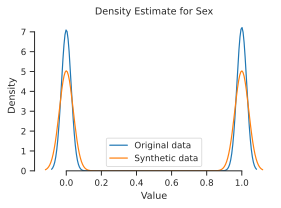

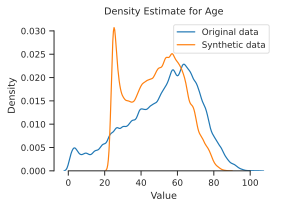

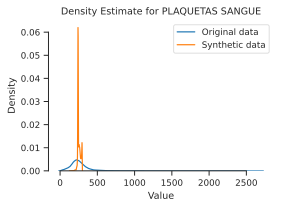

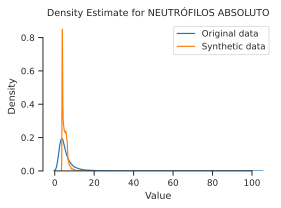

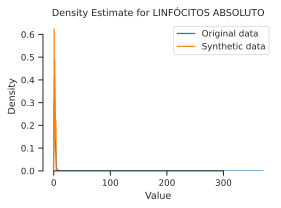

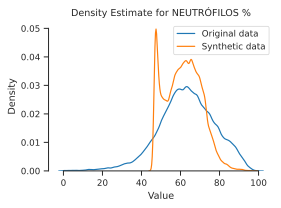

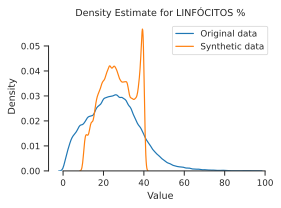

In [134]:
for i, t in enumerate(columns):
    fig, ax = plt.subplots(figsize=(4, 3))
    sns.kdeplot(df_agg[t], label='Original data', ax=ax, bw_adjust=0.5)
    sns.kdeplot(df_samples[t], label='Synthetic data', ax=ax, bw_adjust=0.5)
    ax.set_title(f"Density Estimate for {t}")
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()
    plt.tight_layout()
    sns.despine(trim=True)
    plt.savefig(f'./fig/VAE_dens_{i}.png')
    plt.show()

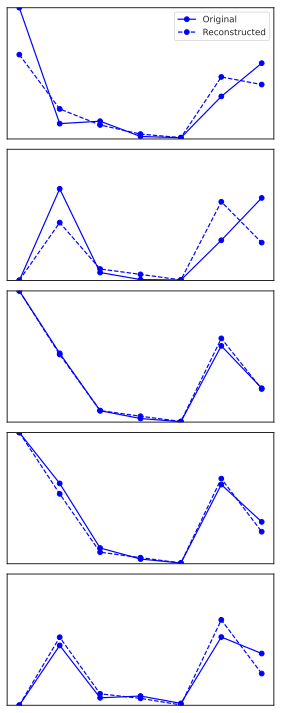

In [135]:
inputs = X_test[:5]
reconstruction_fig(model, inputs, scaler, scaled=True)
plt.savefig(f'./fig/VAE_recon.png')
plt.show()